# Predictive model

The code generates a forecasting model using information from fire data and smoke estimates specific to Farmington, NM. This model is designed to project smoke estimates for each year in the upcoming quarter-century, covering the period from 2021 to 2045. Even thought the requirement is to predict data for the years 2024 - 2049, the smoke estimate is available only till the year 2020. Hence, the change in the forcasting window. Code authored by Adithyaa Vaasen, UW MS DS, as part of the DATA 512 course project.

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [2]:
# Load the smoke estimates
smoke_est = pd.read_csv('C:/Users/adith/Documents/data-512-common-analysis/intermediate/annual_smoke_estimate.csv')

## Model Building

I will be building a predictive model using ARIMA as a starting point. The ARIMA model (AutoRegressive Integrated Moving Average) is chosen for several reasons. 
- Time Series Data: ARIMA is specifically designed for time series data that may have trends or seasonal patterns, which is often the case with environmental data like smoke estimates.
- Simplicity and Performance: It offers a good balance between simplicity and performance, making it a popular choice for many forecasting tasks without requiring large datasets.
- Interpretability: ARIMA models are relatively straightforward to interpret, which can be important when you need to explain your model to stakeholders.
- Statistical Foundation: The model has a strong statistical foundation, providing not just point forecasts but also confidence intervals, which are crucial for risk assessment and planning.

## Section 1: Model Performance Evaluation

In Section 1, we are fitting the model to the entire available historical dataset and using it to make in-sample predictions. This allows us to compare the model's predictions directly with the historical data to visually inspect the model's performance.

In-sample MAE: 1.4761223517681683
In-sample RMSE: 1.863435570966017
In-sample MAPE: 44.184647110954366%


C:\Users\adith\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\adith\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\adith\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


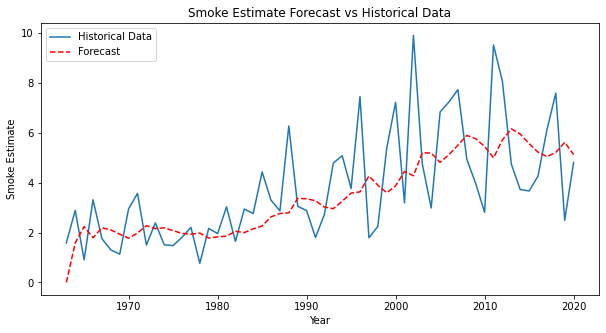

In [3]:
smoke_est['FireYear'] = pd.to_datetime(smoke_est['FireYear'], format='%Y')
smoke_est.set_index('FireYear', inplace=True)

# Fit ARIMA model on the entire dataset
model = ARIMA(smoke_est['SmokeEstimate'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast on the entire dataset (in-sample prediction)
forecast = model_fit.predict(start=smoke_est.index[0], end=smoke_est.index[-1], typ='levels')


# Calculate performance metrics
mae = mean_absolute_error(smoke_est['SmokeEstimate'], forecast)
rmse = sqrt(mean_squared_error(smoke_est['SmokeEstimate'], forecast))
mape = np.mean(np.abs(smoke_est['SmokeEstimate'] - forecast) / smoke_est['SmokeEstimate']) * 100

print(f'In-sample MAE: {mae}')
print(f'In-sample RMSE: {rmse}')
print(f'In-sample MAPE: {mape}%')


# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(smoke_est.index, smoke_est['SmokeEstimate'], label='Historical Data')
plt.plot(forecast.index, forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.title('Smoke Estimate Forecast vs Historical Data')
plt.legend()
plt.show()

Observations based on the in-sample metrics:

- MAE (Mean Absolute Error): This is relatively low, which indicates that on average, the model's predictions are about 1.48 units away from the actual data points. Given the scale of your Smoke Estimate values, this may not be acceptable depending on the thresholds we set for error in the estimation of Smoke.

- RMSE (Root Mean Squared Error): The RMSE is higher than the MAE, as expected, because it gives more weight to larger errors. An RMSE of 1.86 is not significantly higher than the MAE, which suggests there are not many large errors in the predictions.

- MAPE (Mean Absolute Percentage Error): The MAPE is quite high, indicating that the model's predictions are off by an average of 44.18% relative to the actual values. This might suggest that while the magnitude of errors is small in absolute terms, they are quite significant in percentage terms, especially if we are dealing with smaller values of Smoke Estimate where a small absolute error can mean a large percentage error.

## Section 2: Forecasting the next 25 years

In Section 2, we use the same fitted model to forecast out-of-sample predictions for the next 25 years.

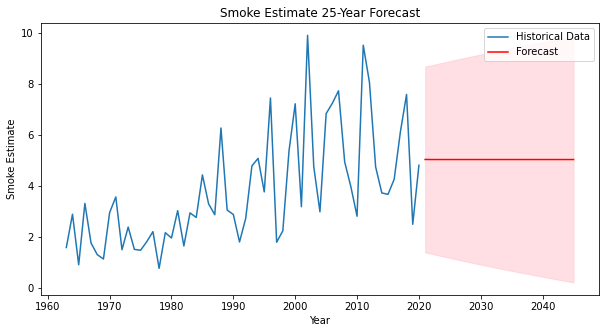

In [4]:
# Forecast the next 25 years with a 95% confidence interval
future_forecast = model_fit.get_forecast(steps=25)
future_mean_forecast = future_forecast.predicted_mean
future_confidence_intervals = future_forecast.conf_int()

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(smoke_est.index, smoke_est['SmokeEstimate'], label='Historical Data')
plt.plot(future_mean_forecast.index, future_mean_forecast, label='Forecast', color='red')
plt.fill_between(future_mean_forecast.index,
                 future_confidence_intervals.iloc[:, 0],
                 future_confidence_intervals.iloc[:, 1], color='pink', alpha=0.5)

plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.title('Smoke Estimate 25-Year Forecast')
plt.legend()
plt.show()

## Summary

The above graph displays the 25-year forecast for smoke estimates using the ARIMA model. The solid red line represents the model's prediction of the central tendency (mean forecast) of smoke estimates. The shaded pink area illustrates the 95% confidence interval, indicating that we can expect with 95% probability that the true future values will fall within this range.

The use of the confidence interval is crucial as it visually presents the uncertainty in the predictions. In our forecast, this interval widens as we move further into the future, reflecting increasing uncertainty. It's important to note that while the forecast provides an estimate of future values, the actual future smoke estimates could be affected by various factors not captured by the historical data and the ARIMA model.

This interval should give us a sense of the potential variability in smoke estimates. In the future, fine tuning the model will help us give a better performance.